In [1]:
#mlp_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#9 July 2018
#
#train an mlp model on the XO dataset, this executes in 14 minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 12
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate training and validation data
N_dots = 2000000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
validate = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
print 'execution time (minutes) = ', (tm.time() - time_start)/60.0
train.tail()

execution time (minutes) =  1.33667765061


,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
1999995,1999995,-4.156082,-3.107059,5.189107,-2.499634,B,0.0,0.0,1.0
1999996,1999996,4.380148,2.876026,5.239964,0.581004,X,1.0,0.0,0.0
1999997,1999997,4.091200,-2.796205,4.955470,-0.599544,B,0.0,0.0,1.0
1999998,1999998,1.731669,-5.289518,5.565759,-1.254416,B,0.0,0.0,1.0
1999999,1999999,-5.861133,-2.085072,6.220965,-2.799809,B,0.0,0.0,1.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

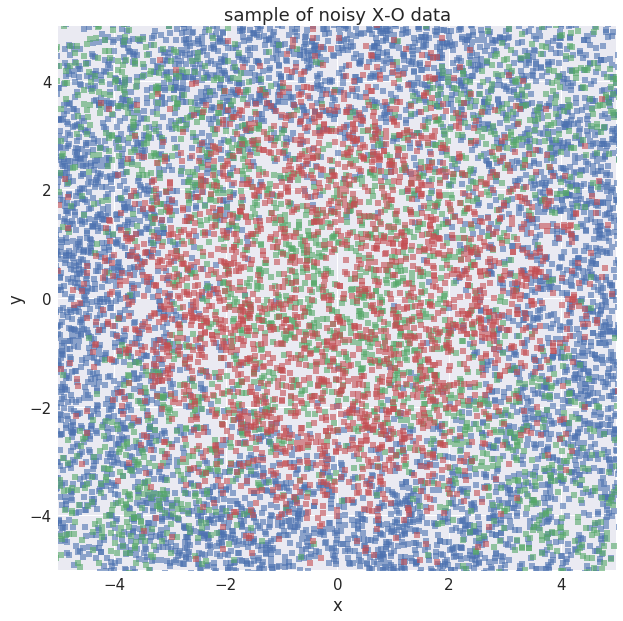

In [6]:
#scatterplot of noisy X-O data
N_plot = 20000
df = train.sample(n=N_plot)
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/training_data.png')

In [7]:
#note class imbalance in training data
train.groupby('class')['id'].count()

class
B    1474928
O     252749
X     272323
Name: id, dtype: int64

In [8]:
#rebalance training data & randomize records
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num')
print train_balanced.groupby('class')['id'].count()
train_balanced.head()

class
B    252749
O    252749
X    272323
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
1041640,1041640,4.625843,-5.060245,6.855983,-0.830216,X,1.0,0.0,0.0,0.000001
1993805,1993805,-0.119042,-1.004930,1.011957,-1.688704,O,0.0,1.0,0.0,0.000002
1457673,1457673,-4.187818,-5.167624,6.651478,-2.251844,X,1.0,0.0,0.0,0.000002
1255417,1255417,3.152173,3.202965,4.493905,0.793390,X,1.0,0.0,0.0,0.000004
1540612,1540612,-0.449922,-2.980745,3.014510,-1.720608,B,0.0,0.0,1.0,0.000005


In [9]:
#rebalance validation data
df = validate
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
validate_balanced = df.sort_values('ran_num')
print validate_balanced.groupby('class')['id'].count()
validate_balanced.head()

class
B    253291
O    253291
X    271526
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
1322285,1322285,-2.852923,-4.331330,5.186481,-2.153243,X,1.0,0.0,0.0,0.000001
1269137,1269137,0.570561,-0.025026,0.571110,-0.043833,O,0.0,1.0,0.0,0.000003
139408,139408,3.445341,-6.120295,7.023417,-1.058075,X,1.0,0.0,0.0,0.000003
350100,350100,-6.170079,-1.622641,6.379877,-2.884430,B,0.0,0.0,1.0,0.000007
434696,434696,-1.023875,-4.026282,4.154427,-1.819816,X,1.0,0.0,0.0,0.000008


In [10]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y', 'r', 'angle']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x_train = train_balanced[x_cols].values
y_train = train_balanced[y_cols].values
print x_train.shape, y_train.shape
x_val = validate_balanced[x_cols].values
y_val = validate_balanced[y_cols].values
print x_val.shape, y_val.shape

N_classes =  3
(777821, 4) (777821, 3)
(778108, 4) (778108, 3)


In [11]:
#this helper function assembles an MLP classifier composed of multiple dense + dropout layers
def mlp_classifier(layers, dropout_fractions, output_activation_fn):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation
    model = Sequential()
    #input layer
    idx = 0
    N = layers[idx]
    df = dropout_fractions[idx]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    if (df):
        model.add(Dropout(df))
    #print N, df
    #hidden layers
    for idx in range(1, len(layers) - 1):
        N = layers[idx]
        df = dropout_fractions[idx]
        model.add(Dense(N, activation='elu'))
        if (df):
            model.add(Dropout(df))
        #print N, df
    #output layer
    N = layers[-1]
    df = None
    model.add(Dense(N, activation=output_activation_fn))
    #print N, df
    #select loss & optimizer
    if (output_activation_fn == 'linear'):
        loss_fn = 'mean_squared_error'
    if (output_activation_fn == 'sigmoid'):
        loss_fn = 'mean_squared_error'
    model.compile(loss=loss_fn, optimizer='adam')
    return model

In [12]:
#build MLP classification model 
N_inputs = x_train.shape[1]
N_outputs = N_classes
layers = [N_inputs, 16, 32, 12, N_outputs]
dropout_fractions = [None, None, 0.2, 0.1, None]
output_activation_fn = 'linear'
print 'layers = ', layers
print 'dropout_fractions = ', dropout_fractions
print 'output_activation_fn = ', output_activation_fn
model = mlp_classifier(layers, dropout_fractions, output_activation_fn)
model.summary()

layers =  [4, 16, 32, 12, 3]
dropout_fractions =  [None, None, 0.2, 0.1, None]
output_activation_fn =  linear


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total para

In [13]:
#fit model to the training data...takes several minute on m4.xl instance...this demo needsa gpu!!!
from time import time
#from keras.callbacks import TensorBoard
#tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
N_training_epochs = 100
batch_size = 2000
time_start = tm.time()
model = mlp_classifier(layers, dropout_fractions, output_activation_fn)
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_val, y_val))
#    , callbacks=[tensorboard])

final validation loss =  0.14049814654781448
dropout_fractions =  [None, None, 0.2, 0.1, None]


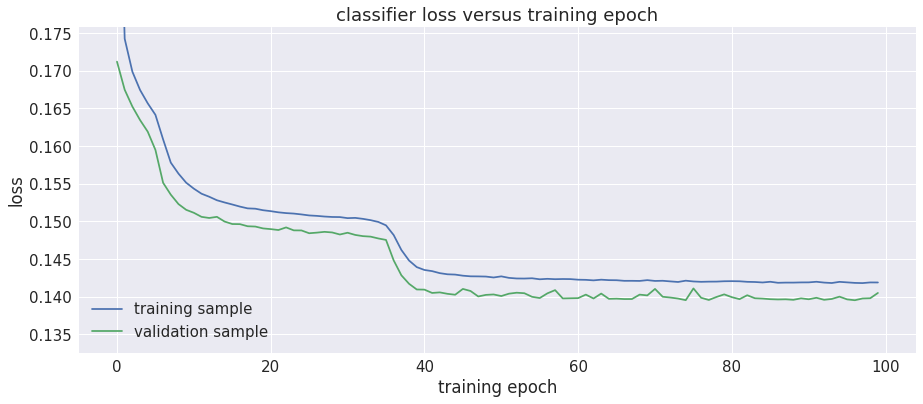

In [14]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]
print 'dropout_fractions = ', dropout_fractions

In [15]:
#generate class predictions on another sample of X-O data
N_dots = 20000
xy = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = xy[x_cols].values
y = xy[y_cols].values
y_pred = model.predict(x)
#normalize class scores
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    xy[y_col] = y_pred[:, idx]
xy['sum'] = xy.O_score + xy.X_score + xy.B_score
for y_col in y_cols:
    xy[y_col] /= xy['sum']
xy['sum'] = xy.O_score + xy.X_score + xy.B_score
idx = (xy.O_score > xy.X_score) & (xy.O_score > xy.B_score)
xy.loc[idx, 'class_pred'] = 'O'
idx = (xy.X_score > xy.B_score) & (xy.X_score > xy.O_score)
xy.loc[idx, 'class_pred'] = 'X'
idx = (xy.B_score > xy.O_score) & (xy.B_score > xy.X_score)
xy.loc[idx, 'class_pred'] = 'B'
xy.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,sum,class_pred
record,,,,,,,,,,,
0,0,-2.484785,-0.236513,2.496016,-3.046694,O,0.234072,0.711614,0.054314,1.0,O
1,1,-1.329003,8.063125,8.171917,1.734152,B,-0.000286,-0.020368,1.020654,1.0,B
2,2,-2.558485,-0.102178,2.560525,-3.101677,B,0.219435,0.721024,0.059542,1.0,O
3,3,5.108488,1.659136,5.371162,0.314033,B,0.100185,0.105064,0.794751,1.0,B
4,4,7.654475,4.713704,8.989438,0.551964,X,0.195629,0.058193,0.746178,1.0,B


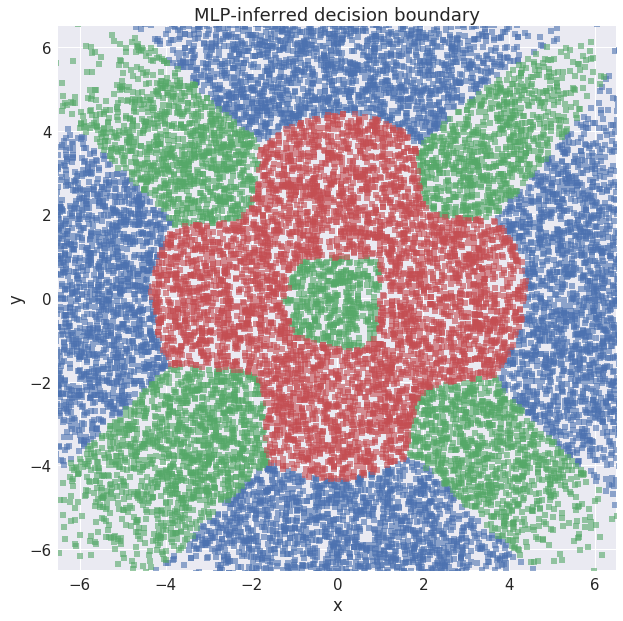

In [16]:
#scatterplot showing model's predicted decision boundaries
df = xy
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/mlp_decision_boundary.png')

In [17]:
#model accuracy
idx = (xy['class'] == xy['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.7024


In [18]:
#save model
model.save('mlp_model.h5') 

In [19]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  12.8141287843
